In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import numpy as np

# Charger vos données
immo = pd.read_csv('immo.csv')

# Calcule de l'âge de la vente (en jours) par rapport à aujourd'hui
immo['prev_sold_date'] = pd.to_datetime(immo['prev_sold_date'])
immo['age_of_sale'] = (datetime.now() - immo['prev_sold_date']).dt.days

# Sélection des colonnes pour le One-Hot Encoding et la standardisation
colonnes_numeriques = ['bed', 'bath', 'acre_lot', 'house_size','age_of_sale']
colonnes_categorielles = ['city', 'state', 'zip_code']

# Transformer les données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', QuantileTransformer(), colonnes_numeriques),
        ('cat', OneHotEncoder(), colonnes_categorielles)
    ])

X = immo.drop('price', axis=1)
y = immo['price']

# Appliquer la transformation
X_transformed = preprocessor.fit_transform(X)
X_transformed_dense = X_transformed.toarray()

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X_transformed_dense, y, test_size=0.2, random_state=42)

# Construction du modèle ANN
model = Sequential()
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1)) # Couche de sortie pour la régression


# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entraînement du modèle
model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64)

# Évaluation du modèle
y_pred = model.predict(X_test)
import math
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')




Epoch 1/30

335/335 [==============================] - 12s 26ms/step - loss: 2093278035968.0000 - val_loss: 1530539540480.0000
Epoch 2/30
335/335 [==============================] - 8s 24ms/step - loss: 1424063856640.0000 - val_loss: 1145193758720.0000
Epoch 3/30
335/335 [==============================] - 8s 23ms/step - loss: 1160994488320.0000 - val_loss: 1078591029248.0000
Epoch 4/30
335/335 [==============================] - 7s 22ms/step - loss: 1081736888320.0000 - val_loss: 1045416116224.0000
Epoch 5/30
335/335 [==============================] - 8s 23ms/step - loss: 1013640069120.0000 - val_loss: 1029517475840.0000
Epoch 6/30
335/335 [==============================] - 8s 23ms/step - loss: 942243119104.0000 - val_loss: 996235935744.0000
Epoch 7/30
335/335 [==============================] - 8s 23ms/step - loss: 931833380864.0000 - val_loss: 1016079974400.0000
Epoch 8/30
335/335 [==============================] - 8s 23ms/step - loss: 885075542016.0000 - val_loss: 985746702336.0000
E

In [2]:
# Calculer les erreurs
erreurs = y_test - y_pred.flatten()

# Créer un DataFrame pour l'analyse
df_erreurs = pd.DataFrame({'Vraies Valeurs': y_test, 'Prédictions': y_pred.flatten(), 'Erreur': erreurs})

# Trier le DataFrame par les plus grandes erreurs absolues
df_erreurs['Erreur Absolue'] = df_erreurs['Erreur'].abs()
df_erreurs = df_erreurs.sort_values(by='Erreur Absolue', ascending=False)

# Afficher les cas avec les plus grandes erreurs
print(df_erreurs.head())

# Analyser les cas spécifiques
# Par exemple, vous pouvez examiner les caractéristiques de ces observations
# pour voir s'il y a des anomalies ou des tendances particulières.


       Vraies Valeurs  Prédictions       Erreur  Erreur Absolue
31975      15500000.0   1714579.00  13785421.00     13785421.00
5980       23750000.0  11006409.00  12743591.00     12743591.00
3154       18899000.0   6207471.00  12691529.00     12691529.00
14028      25000000.0  13031783.00  11968217.00     11968217.00
1937       15000000.0   3085693.25  11914306.75     11914306.75


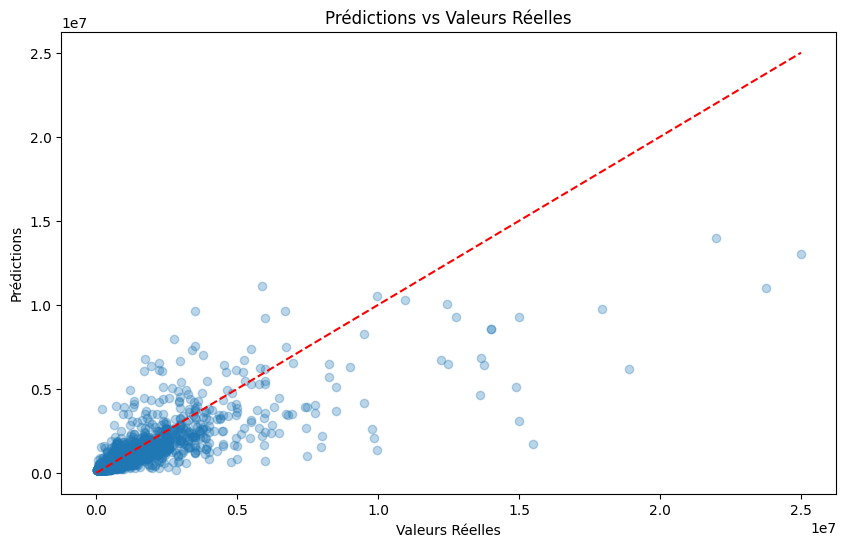

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des résidus
#residus = y_test - y_pred

# Graphique de Prédiction vs Réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles')
plt.show()